<a href="https://colab.research.google.com/github/satvik-dixit/feature_importance/blob/main/FI_egemaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition Demo

A demo containing all steps of speech emotion recoginition using the EmoDB dataset. The demo has been divided into 3 phases:
- Phase 1: Loading audio files and extracting metadata
- Phase 2: Embedding Extraction
- Phase 3: Downstream Task - Speech Emotion Recognotion



### About EmoDB:
- A German database of emotional speech
- 800 recordings
- 10 actors (5 males and 5 females)
- 7 emotions: anger, neutral, fear, boredom, happiness, sadness, disgust

### References:
- Dataset: http://emodb.bilderbar.info/index-1280.html
- Paper: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.130.8506&rep=rep1&type=pdf

Lets start by importing a few packages.


### Importing packages

In [41]:
!git clone -q https://github.com/GasserElbanna/serab-byols.git
!python3 -m pip install -q -e ./serab-byols

!pip install -q tqdm==4.60.0
!pip install -q opensmile

fatal: destination path 'serab-byols' already exists and is not an empty directory.


In [ ]:
# code to restart runtime so the packages get installed
import os
os.kill(os.getpid(), 9)

In [1]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from random import sample

import librosa
import soundfile as sf

import torch
import opensmile
import serab_byols

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')


In [2]:
! pip install -q kaggle

from google.colab import files
files.upload()

# Name directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Phase 1: Loading audio files and extracting metadata

Includes downloading the dataset, loading audio files, resampling audio files, extracting metadata



### Defining a function for loading and resampling audio files

In [3]:
# Defining a function for loading and resampling audio files

def load_audio_files(audio_files, resampling_frequency=16000, audio_list=None):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_files: string
      The paths of the wav files 
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list 
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''
  # Making audio_list
  if audio_list is None:
    audio_list = []

  # Resampling
  for audio in audio_files:
    signal, fs = librosa.load(audio, sr=resampling_frequency)
    audio_list.append(torch.from_numpy(signal))
      
  return audio_list
        

### Loading and resampling audiofiles and collecting metadata on EmoDB dataset

In [4]:
# # Phase_1
# # Load dataset
# ! kaggle datasets download -q -d piyushagni5/berlin-database-of-emotional-speech-emodb
# ! unzip -q berlin-database-of-emotional-speech-emodb.zip

# # Resample dataset
# audio_files = glob('/content/wav/*.wav')
# audio_list = load_audio_files(audio_files, resampling_frequency=16000)

# # Extracting metadata (speakers and labels)
# labels = np.array(list(map(lambda x: os.path.basename(x).split('.')[0][-2], audio_files)))
# speakers = np.array(list(map(lambda x: os.path.basename(x)[:2], audio_files)))

# # ---------------------------------------------------------------------------------------------------

# # Verify phase_1
# print('Number of audio files: {}'.format(len(audio_list)))
# print('Number of speaker classes: {}'.format(len(set(speakers))))
# print('Speaker classes: {}'.format(set(speakers)))
# print('Number of speakers: {}'.format(len(speakers)))
# print('Speakers:')
# print(speakers)
# print('Number of label classes: {}'.format(len(set(labels))))
# print('Label classes: {}'.format(set(labels)))
# print('Number of labels: {}'.format(len(labels)))
# print('Labels:')
# print(labels)


In [5]:
# Phase_1
# Load dataset
! kaggle datasets download -q -d ejlok1/cremad
! unzip -q cremad.zip

# Load and resample audio files
audio_files = glob(os.path.join('/content/AudioWAV','*.wav'))
audio_list = load_audio_files(audio_files, resampling_frequency=16000)

# Make speakers list and labels list 
speakers = []
labels = []
for audio_file in audio_files:
  file_name = audio_file.split('/')[3]
  speakers.append(int(file_name[:4]))
  labels.append(file_name[9:12])


# Verify phase_1
print('Number of audio files: {}'.format(len(audio_list)))
print('Number of speaker classes: {}'.format(len(set(speakers))))
print('Speaker classes: {}'.format(set(speakers)))
print('Number of speakers: {}'.format(len(speakers)))
print('Number of label classes: {}'.format(len(set(labels))))
print('Label classes: {}'.format(set(labels)))
print('Number of labels: {}'.format(len(labels)))

Number of audio files: 7442
Number of speaker classes: 91
Speaker classes: {1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023}
Number of speakers: 7442
Number of label classes: 6
Label classes: {'ANG', 'DIS', 'NEU', 'SAD', 'HAP', 'FEA'}
Number of labels: 7442


# Phase 2: Embedding Extraction
Includes extracting features using
- Deep learning based methods: Hybrid BYOL-S
- DSP based methods: openSMILE compare, openSMILE egemaps

### Audio embeddings extraction functions

In [6]:
# Defining a function for generating audio embedding extraction models

model = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
egemaps_feature_names = model.column_names

def audio_embeddings_model(model_name):
  '''
  Generates model for embedding extraction 
  
  Parameters
  ------------
  mode_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'

  Returns
  ------------
  model: object
      The embedding extraction model
  '''
  if model_name=='hybrid_byols':
    model_name = 'cvt'
    checkpoint_path = "serab-byols/checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-osandbyolaloss6373-e100-bs256-lr0003-rs42.pth"
    model = serab_byols.load_model(checkpoint_path, model_name)
  elif model_name=='compare':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  elif model_name=='egemaps':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  return model


# Defining a function for embedding exctraction from the audio list

def audio_embeddings(audio_list, model_name, model, sampling_rate=16000):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_list: list
      A list of arrays, one array for each audio file
  model_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'
  model: object
      The embedding extraction model generated by audio_embeddings_model function
  sampling_rate: int
      The sampling rate, 16 kHz by default

  Returns
  ------------
  embeddings_array: array
      The array containg embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  if model_name=='hybrid_byols':
    embeddings_array = serab_byols.get_scene_embeddings(audio_list, model)
  else:
    embeddings_list = []
    for i in tqdm(range(len(audio_list))):
      embeddings = model.process_signal(audio_list[i], sampling_rate)
      embeddings_list.append(torch.tensor(embeddings.values[0], dtype=torch.float32))
    embeddings_array = torch.stack(embeddings_list)
  return embeddings_array


### Audio embeddings extraction on EmoDB

In [7]:
# Phase_2

# Hybrid BYOLS
model = audio_embeddings_model(model_name='hybrid_byols')
embeddings_array_byols = audio_embeddings(audio_list, model_name='hybrid_byols', model=model)

# EmoDB compare
model = audio_embeddings_model(model_name='compare')
embeddings_array_compare = audio_embeddings(audio_list, model_name='compare', model=model)

# EmoDB egemaps
model = audio_embeddings_model(model_name='egemaps')
embeddings_array_egemaps = audio_embeddings(audio_list, model_name='egemaps', model=model)

# ---------------------------------------------------------------------------------------------------

# Verify Phase_2
models = ['hybrid_byols', 'compare', 'egemaps']
embeddings_arrays = {'hybrid_byols': embeddings_array_byols, 'compare':embeddings_array_compare, 'egemaps':embeddings_array_egemaps}

for model in models:
  print()
  print()
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the embeddings array is {}'.format(embeddings_arrays[model].shape))
  print('The embeddings array is: ')
  print((embeddings_arrays[model]))


100%|██████████| 7442/7442 [12:42<00:00,  9.76it/s]



MODEL: hybrid_byols

The shape of the embeddings array is torch.Size([7442, 2048])
The embeddings array is: 
tensor([[ 3.7921,  3.4782,  1.8397,  ...,  3.1391, -2.1357,  3.9936],
        [ 5.9278,  2.8341,  2.3030,  ...,  3.3385, -0.5926,  3.8766],
        [ 5.1540,  3.0963,  1.3947,  ...,  4.1714,  0.4160,  4.7181],
        ...,
        [ 4.5259,  4.0733,  1.4631,  ...,  3.8937, -0.8905,  3.5641],
        [ 6.6746,  3.1640,  1.4519,  ...,  3.9940,  0.6954,  3.9179],
        [ 3.5688,  3.2886,  2.0273,  ...,  2.6394, -0.5633,  4.4401]])


MODEL: compare

The shape of the embeddings array is torch.Size([7442, 6373])
The embeddings array is: 
tensor([[8.8186e-01, 4.8161e-01, 2.4749e-01,  ..., 5.0786e+01, 9.2053e+01,
         3.8685e+01],
        [6.0670e-01, 4.5238e-01, 2.2321e-01,  ..., 4.8093e+01, 9.9742e+01,
         5.9351e+01],
        [1.3345e+00, 6.3687e-01, 4.4693e-02,  ..., 3.1391e+01, 9.7125e+01,
         4.3526e+01],
        ...,
        [5.7067e-01, 4.1379e-01, 2.3645e-01, 

# Phase 3: Downstream Task - Speech Emotion Recognotion
Includes speaker normalisation, train test splitting and hyperparameter tuning using logistic regression, SVM and random forest classification 

### Speaker normalisation functions

In [14]:
# Defining a function for speaker normalisation using standard scaler

def speaker_normalisation(embeddings_array, speakers):
  '''
  Normalises embeddings_array for each speaker
  
  Parameters
  ------------
  embeddings_array: array
      The array of embeddings, one row for each audio file
  speakers: list 
      The list of speakers

  Returns
  ------------
  embeddings_array: array
      The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  speaker_ids = set(speakers)
  for speaker_id in speaker_ids:
    speaker_embeddings_indices = np.where(np.array(speakers)==speaker_id)[0]
    speaker_embeddings = embeddings_array[speaker_embeddings_indices,:]
    scaler = StandardScaler()
    normalised_speaker_embeddings = scaler.fit_transform(speaker_embeddings)
    embeddings_array[speaker_embeddings_indices] = torch.tensor(normalised_speaker_embeddings).float()
  return embeddings_array


### Speaker normalisation on EmoDB

In [15]:
# Normalised arrays
normalised_embeddings_byols = speaker_normalisation(embeddings_array_byols, speakers)
normalised_embeddings_compare= speaker_normalisation(embeddings_array_compare, speakers)
normalised_embeddings_egemaps = speaker_normalisation(embeddings_array_egemaps, speakers)


# Verifying normalised_embeddings_arrays

normalised_embeddings_arrays = {'hybrid_byols': normalised_embeddings_byols, 'compare':normalised_embeddings_compare, 'egemaps':normalised_embeddings_egemaps}

for model in models:
  print()
  print()
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the normalised embeddings array is: {}'.format(normalised_embeddings_arrays[model].shape))
  print('Normalised Embeddings Array:')
  print((normalised_embeddings_arrays[model]))
  columnwise_mean = torch.mean(normalised_embeddings_arrays[model], 0)
  print('Columnwise_mean:')
  print(columnwise_mean)
  if torch.all(columnwise_mean < 10**(-6)):
    print('PASSED: All means are less than 10**-6')
  else:
    print('FAILED: All means are NOT less than 10**-6')




MODEL: egemaps

The shape of the normalised embeddings array is: torch.Size([7442, 88])
Normalised Embeddings Array:
tensor([[-0.2637,  0.1587, -0.2465,  ..., -0.3631,  0.2754, -0.1750],
        [-0.1543,  3.1743, -0.4470,  ...,  0.4497,  1.4209, -0.3964],
        [ 0.5635, -0.8686,  0.6910,  ..., -0.1832,  0.0078,  0.3362],
        ...,
        [-0.3396,  0.9819, -0.5805,  ..., -0.8736, -0.6958, -0.4006],
        [ 0.5161,  0.8994, -0.0524,  ..., -0.3967, -0.3173,  0.4251],
        [ 0.7120, -0.9240,  0.9882,  ..., -0.7713,  0.1064, -0.8049]])
Columnwise_mean:
tensor([-1.0252e-09,  4.1007e-09,  2.5630e-10,  1.2815e-09,  1.1213e-09,
        -2.5630e-10,  1.5378e-09,  0.0000e+00,  2.5630e-10,  1.0252e-09,
        -2.5630e-09,  0.0000e+00, -2.5630e-10, -1.5378e-09,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.5378e-09,  2.0504e-09,  2.0504e-09,
         1.0252e-09,  1.5378e-09,  5.1259e-10, -1.5378e-09,  0.0000e+00,
        -1.0252e-09, -1.0252e-09, -5.1259e-10, -1.5378e-09,  1.02

### Label Division

In [16]:
# Defining a function for selecting a part of the dataset containing only the required labels

def label_division(embeddings_array, labels, required_labels):
  '''
  Normalises embeddings_array for each speaker
  
  Parameters
  ------------
  embeddings_array: array
      The array of embeddings, one row for each audio file
  speakers: list 
      The list of speakers

  Returns
  ------------
  embeddings_array: array
      The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  print(embeddings_array.shape)
  # unique_labels = set(labels)

  final_embeddings_array = {}
  final_labels_list = {}
  for label in required_labels:
    print(label)
    label_indices = np.where(np.array(labels)==label)[0]
    print(label_indices)
    label_embeddings = embeddings_array[label_indices,:]
    print(label_embeddings.shape)
    final_embeddings_array[label] = label_embeddings
    final_labels_list[label] = [label]*len(label_indices)
    print(final_labels_list[label])
  final_embeddings = np.vstack((final_embeddings_array[required_labels[0]], final_embeddings_array[required_labels[1]]))
  final_labels = final_labels_list[required_labels[0]]+final_labels_list[required_labels[1]]
  print(final_embeddings.shape)
  print(final_labels)
  return final_embeddings, final_labels


### Label Division on CREMA-D

In [17]:
labeled_array_egemaps, labels_list_egemaps = label_division(normalised_embeddings_egemaps, labels, ['NEU', 'ANG'])
labeled_array_byols, labels_list_byols = label_division(normalised_embeddings_byols, labels, ['NEU', 'ANG'])
labeled_array_compare, labels_list_compare = label_division(normalised_embeddings_compare, labels, ['NEU', 'ANG'])

# labeled_array_egemaps, labels_list_egemaps = label_division(normalised_embeddings_egemaps, labels, ['N', 'A'])
# labeled_array_byols, labels_list_byols = label_division(normalised_embeddings_byols, labels, ['N', 'A'])
# labeled_array_compare, labels_list_compare = label_division(normalised_embeddings_compare, labels, ['N', 'A'])

labeled_arrays = {'hybrid_byols': labeled_array_byols, 'compare': labeled_array_compare, 'egemaps': labeled_array_egemaps}
label_lists = {'hybrid_byols': labels_list_byols, 'compare': labels_list_compare, 'egemaps': labels_list_egemaps}

torch.Size([7442, 88])
NEU
[   0    7   15 ... 7432 7435 7439]
torch.Size([1087, 88])
['NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NE

# Feature Importance

## Method 1: permutation_importance

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

# Do we do hyperparameter tuning? (Error: GridSearchCV has no coef_)
def permutation_importance_method(X, y):
  model = KNeighborsClassifier()
  avg_importance = np.zeros((10, 88))
  for i in range(10):
    model.fit(X, y)
    results = permutation_importance(model, X, y, scoring='accuracy')
    importance = results.importances_mean
    avg_importance[i] = importance
  importance = np.mean(avg_importance, axis=0)
  # print(importance.shape)
  fig, ax = plt.subplots(figsize=(12, 20))
  bars = ax.barh(egemaps_feature_names, importance)


### Models: Logistic Regression + SVM + Random Forest Classifier

MODEL: egemaps


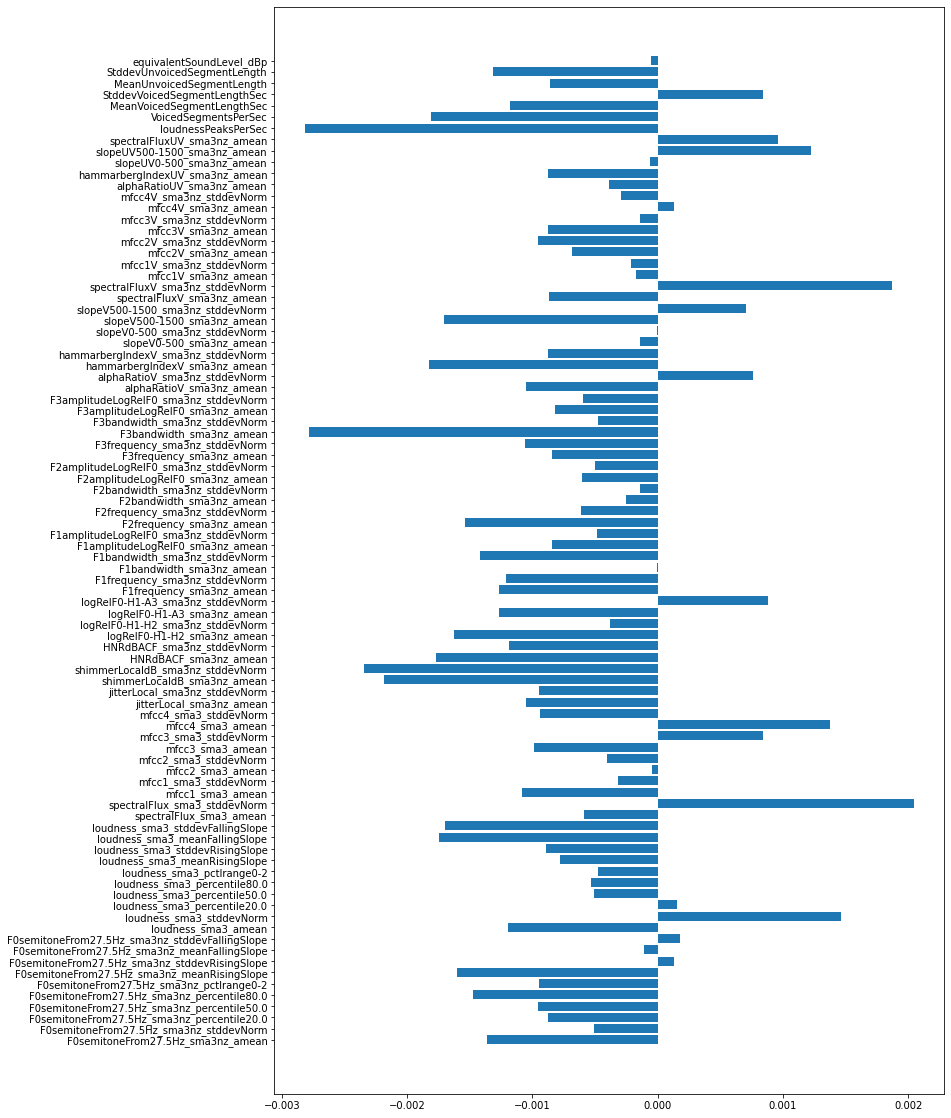

In [19]:
# models = ['compare', 'egemaps']
models = ['egemaps']
for model in models:
  print('MODEL: {}'.format(model))
  permutation_importance_method(labeled_arrays[model], label_lists[model])


## Method 2: Standard Methods

### Model 1: Logistic Regression

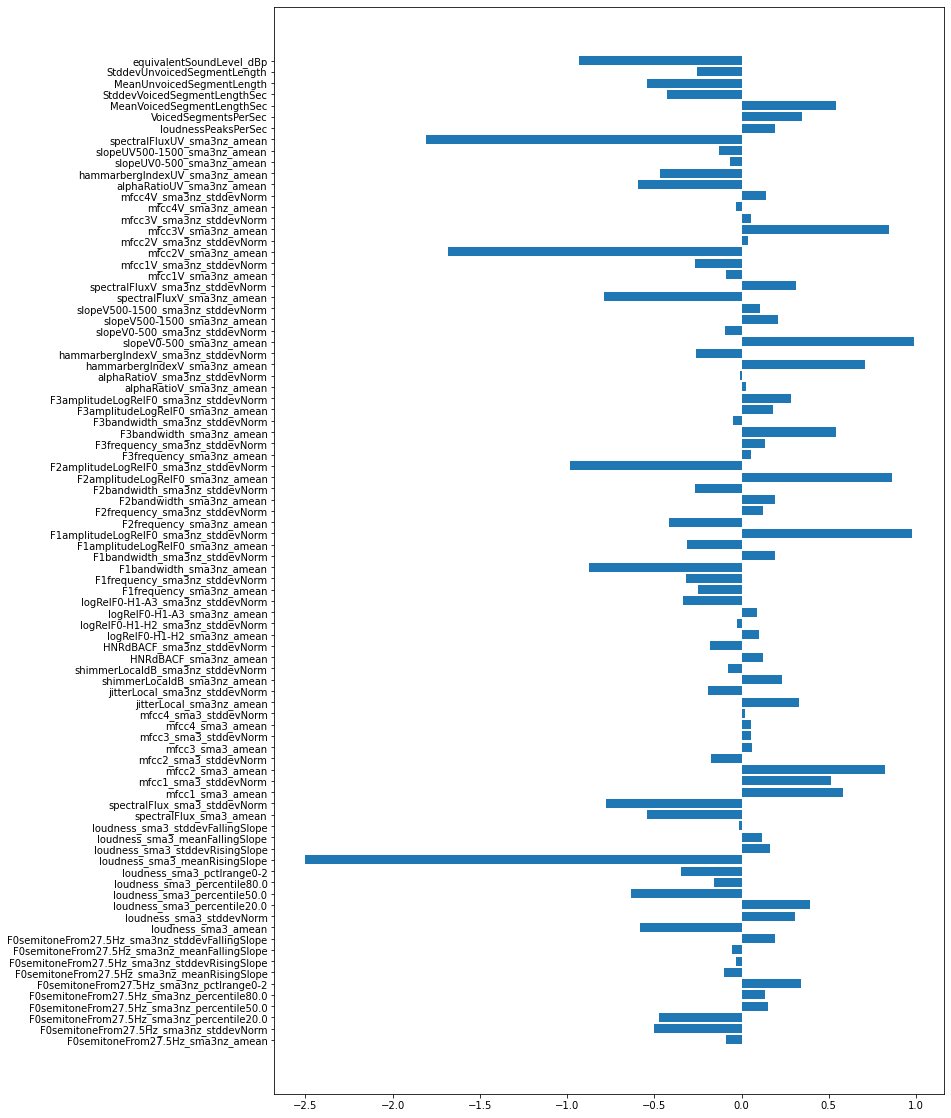

In [20]:
# models = ['compare', 'egemaps']
models = ['egemaps']
for model in models: 
  classifier = LogisticRegression()
  avg_importance = np.zeros((10, 88))
  for i in range(10):
    classifier.fit(labeled_arrays[model], label_lists[model])
    importance = classifier.coef_
    avg_importance[i] = importance[0]
  importance = np.mean(avg_importance, axis=0)
  # print(importance.shape)
  # print(importance)
  fig, ax = plt.subplots(figsize=(12, 20))
  bars = ax.barh(egemaps_feature_names, importance)

### Model 2: SVM

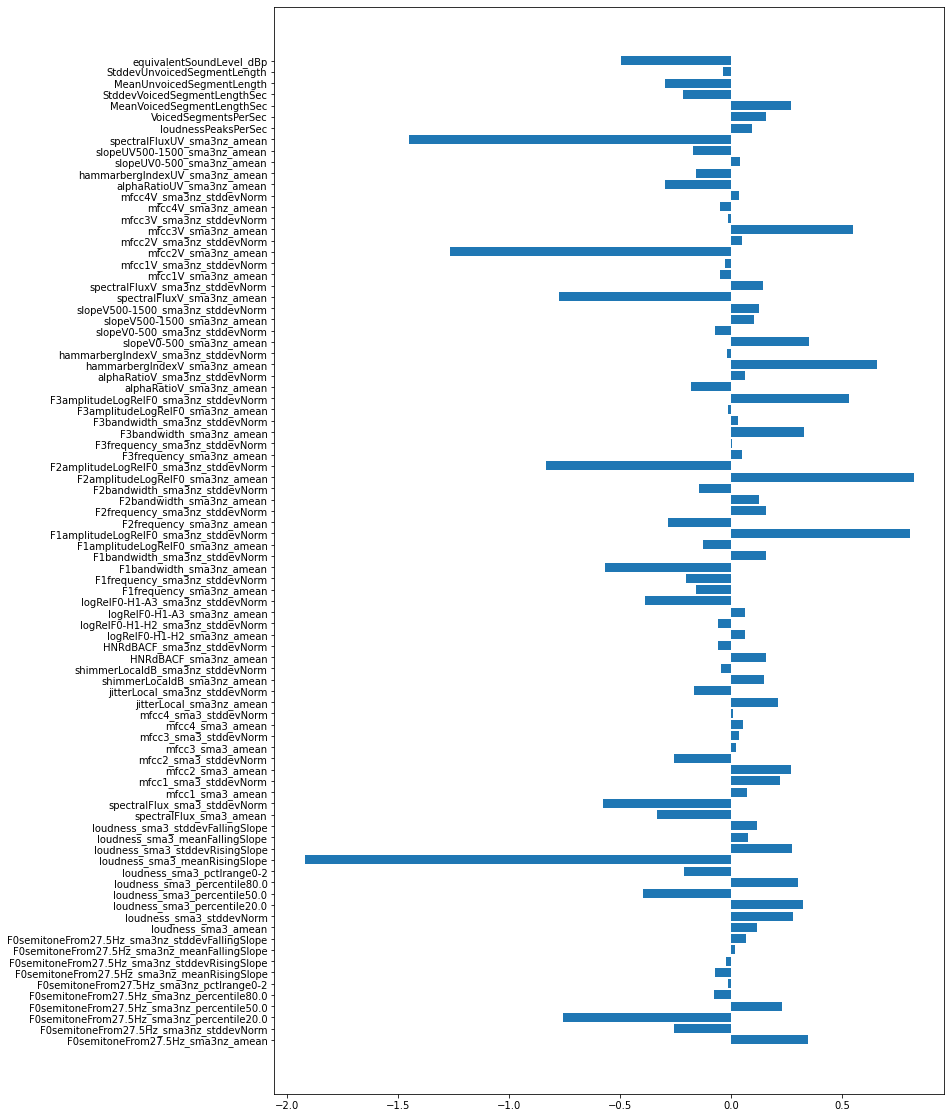

In [21]:
# models = ['compare', 'egemaps']
models = ['egemaps']
for model in models:
  classifier = SVC(kernel='linear')
  classifier.fit(labeled_arrays[model], label_lists[model])
  importance = classifier.coef_
  # print(importance.shape)
  # print(importance)
  fig, ax = plt.subplots(figsize=(12, 20))
  bars = ax.barh(egemaps_feature_names, importance[0])

### Model 3: Random Forest Classifier

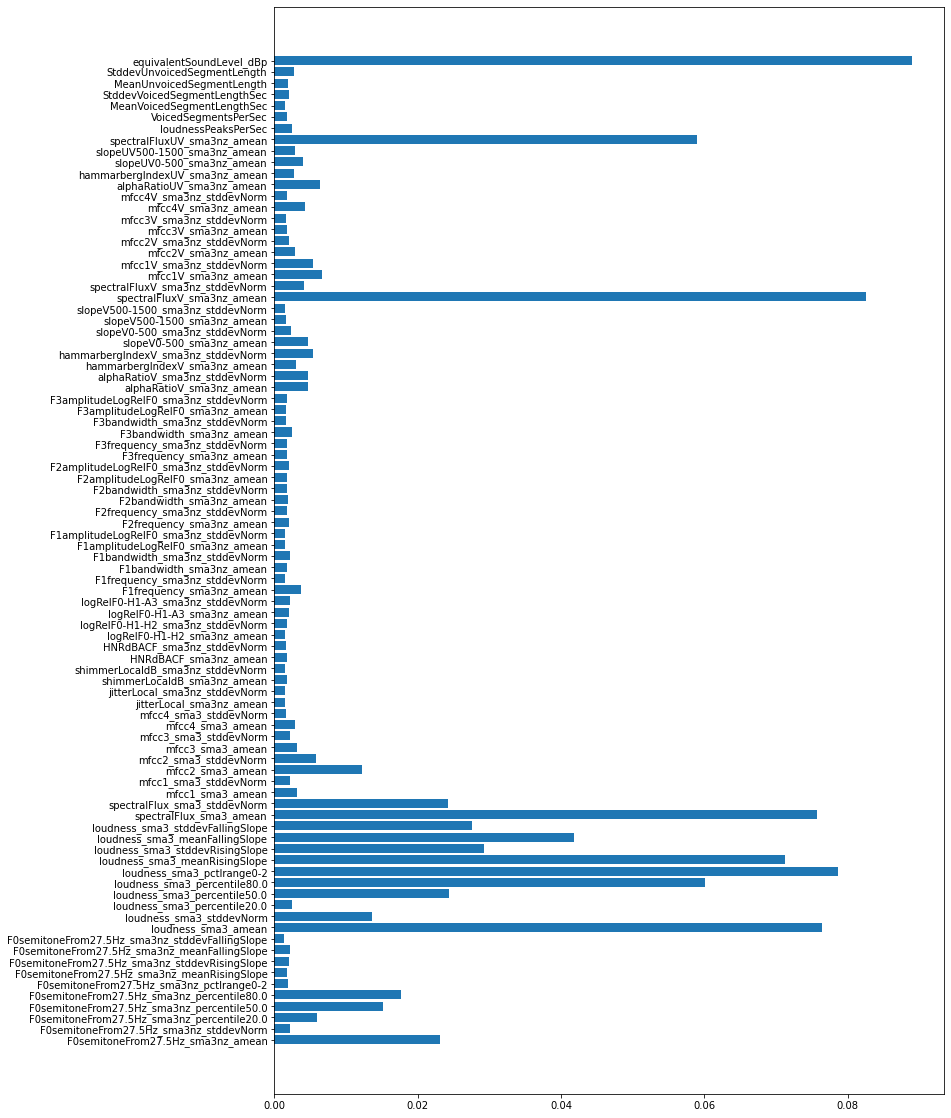

In [22]:
# models = ['compare', 'egemaps']
models = ['egemaps']
for model in models:
  classifier = RandomForestClassifier()
  avg_importance = np.zeros((10, 88))
  for i in range(10):
    classifier.fit(labeled_arrays[model], label_lists[model])
    importance = classifier.feature_importances_
    avg_importance[i] = importance
  importance = np.mean(avg_importance, axis=0)
  # print(importance.shape)
  fig, ax = plt.subplots(figsize=(12, 20))
  bars = ax.barh(egemaps_feature_names, importance)